<a href="https://colab.research.google.com/github/danielsaggau/causal-dyna-fair/blob/master/delayed_impact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Delayed Impact 

This notebook explores causal inference in the context of decision making with dynamics. As our starting point, we use the lending simulator introduced in [Delayed Impact of Fair Machine Learning](https://arxiv.org/abs/1803.04383). 

To connect this simulator with causal inference, we exploit it's representation as a structural causal model introduced in [Causal Modeling for Fairness in Dynamical Systems](https://arxiv.org/abs/1909.09141). All of the interventions we consider, including the "credit bureau" intervention, were introduced by Creager et al. For more details, see

1. Creager, Elliot, et al. "Causal Modeling for Fairness in Dynamical Systems." International Conference on Machine Learning. 2020.

2. Liu, Lydia, et al. "Delayed Impact of Fair Machine Learning." International Conference on Machine Learning. 2018.

In [ ]:
%load_ext autoreload
%autoreload 2
!pip install whynot

In [ ]:
import matplotlib.pylab as plt
from tqdm.auto import tqdm

import whynot as wn
import whynot.traceable_numpy as np

from whynot.simulators.delayed_impact.simulator import INV_CDFS, GROUP_SIZE_RATIO

## Constructing the experiment

For illustrative purposes, we show how to construct the credit bureau intervention from [Creager et al.](https://arxiv.org/abs/1909.09141) in WhyNot. The user writes a handful of small functions, each determining a different aspect of the causal experiment.

### Sample initial states
Each state in the delayed impact model consists of an agent parameterized by a binary "group" indicator and a credit score.
We sample group membership and credit scores based on historical FICO data.

In [5]:
def sample_initial_states(rng):
    group = int(rng.uniform() < GROUP_SIZE_RATIO[1])
    # Compute credit score via inverse CDF trick
    score = INV_CDFS[group](rng.uniform())
    return wn.delayed_impact.State(group=group, credit_score=score)

### Set up simulator configuration
The simulator is parameterized by lending thresholds for each group $\tau_0$ and $\tau_1$, which we instantiate as `parameters` to allow the user to vary them
during experiments.

In [6]:
@wn.parameter(
    name="threshold_g0", default=550, description="Lending threshold for group 0")
@wn.parameter(
    name="threshold_g1", default=550, description="Lending threshold for group 1")
def construct_config(threshold_g0, threshold_g1):
    """Return the experimental config for runs without intervention"""
    return wn.delayed_impact.Config(
        start_time=0, end_time=1, threshold_g0=threshold_g0, threshold_g1=threshold_g1
    )

### Define outcome measurement
The outcome measurement we measure is the change in an agent's credit score from time step 0 to time step 1, along with the profit
the bank earns for this individual.

In [7]:
def extract_outcomes(run):
    # Recall states are individuals in this model
    agent_t0 = run.states[0]
    agent_t1 = run.states[1]
    return [agent_t1.credit_score - agent_t0.credit_score, agent_t1.profits]

### Define the intervention

The intervention we consider is the implementation of a credit bureau that treats intermediates between the individual and the lender
and reports credit scores of $\min(\text{score}, 600)$, as discussed in [Creager et al.](https://arxiv.org/abs/1909.09141).

In [8]:
def creditscore_threshold(score):
    """Alternate credit bureau scoring policy."""
    return max(score, 600)

def intervention():
    return wn.delayed_impact.Intervention(credit_scorer=creditscore_threshold, time=0)

### Put the components together
We put each of these components in a `DynamicsExperiment` object to create an the `CreditBureauExperiment`. Importantly, we assume all agents in the model
have the credit bureau intervention, so they are "treated" in the causal inference sense with probability 1.0

In [9]:
CreditBureauExperiment = wn.DynamicsExperiment(
    name="CreditBureauExperiment",
    description="Intervention on the credit scoring mechanism.",
    simulator=wn.delayed_impact,
    simulator_config=construct_config,
    intervention=intervention,
    state_sampler=sample_initial_states,
    propensity_scorer=1.0,
    outcome_extractor=extract_outcomes,
    covariate_builder=lambda run: run.initial_state.group,
)

## Running the experiment

Compute average credit score changes for the minority group, as well as institutional profits, as the credit score threshold for the minority varies from 300 to 800.
Throughout, the majority threshold is fixed.

In [10]:
minority_thresholds = list(range(300, 800, 10))

average_min_score_changes = []
average_inst_profits = []
for tau_0 in tqdm(minority_thresholds):
    # Run the experiment to generate the dataset
    dataset = CreditBureauExperiment.run(threshold_g0=tau_0, num_samples=1000, parallelize=True)    
    
    # Only consider score changes for the minority group
    minority_locs = dataset.covariates[:, 0] == 0
    minority_treated_locs = minority_locs & (dataset.treatments == 1)

    score_changes = dataset.outcomes[:, 0]
    minority_changes = score_changes[minority_treated_locs]
    average_min_score_changes.append(np.mean(minority_changes))
        
    # Report profits over the entire group
    ind_profits = dataset.outcomes[:, 1][dataset.treatments == 1]
    average_inst_profits.append(np.mean(ind_profits))

## Visualizing the results

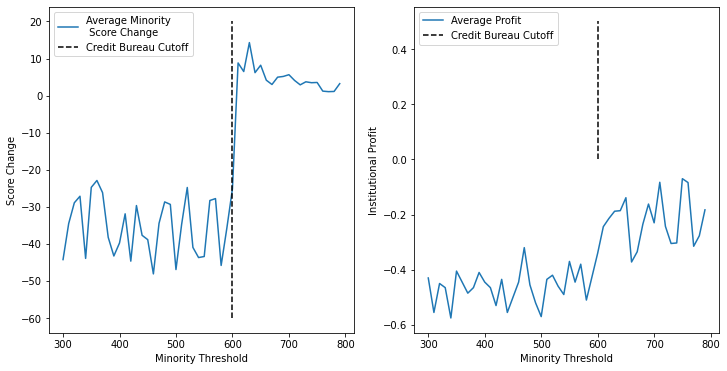

In [14]:
_, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(minority_thresholds, average_min_score_changes, label="Average Minority\n Score Change")
axs[0].plot([600] * 20, np.linspace(-60, 20, 20), label="Credit Bureau Cutoff", linestyle="--", color="black")
axs[0].legend()
axs[0].set_xlabel("Minority Threshold")
axs[0].set_ylabel("Score Change")
axs[1].plot(minority_thresholds, average_inst_profits, label="Average Profit")
axs[1].plot([600] * 20, np.linspace(0, 0.5, 20), label="Credit Bureau Cutoff", linestyle="--", color="black")
axs[1].set_xlabel("Minority Threshold")
axs[1].set_ylabel("Institutional Profit")
axs[1].legend();

# Treatment effect estimation with confounding

Now, we slightly modify the CreditBureau example to show how WhyNot can also be used to address causal inference questions. Rather than exposing all agents to the credit bureau intervention, we imagine
members of the minority group are more likely to receive the credit bureau intervention (75% chance) compared to members of the majority group (20% chance). Using this data, we wish to estimate the population-level causal effect of the credit intervention.


## Constructing the experiment

We slightly modify the `CreditBureauExperiment` to include confounded treatment assignment by changing the ``propensity_scorer`` function.

In [15]:
def propensity_scorer(untreated_run):
    """Assign minority to treatment 75% of the time, compared to 25% for the majority"""
    return  0.75 * (untreated_run.initial_state.group == 0) + 0.2 * (untreated_run.initial_state.group == 1)

In [16]:
BiasedCreditBureauExperiment = wn.DynamicsExperiment(
    name="BiasedCreditBureauExperiment",
    description="Intervention on the credit scoring mechanism, with treatment bias.",
    simulator=wn.delayed_impact,
    simulator_config=construct_config,
    intervention=intervention,
    state_sampler=sample_initial_states,
    propensity_scorer=propensity_scorer,
    outcome_extractor=extract_outcomes,
    # Only covariate is group membership, which is a confounder for this experiment.
    covariate_builder=lambda run: [run.initial_state.group, run.initial_state.credit_score]
)

## Running the experiment and generating causal graphs

Run the experiment to generate an observational dataset. Using `causal_graph=True` generates the causal graph associated with the experiment.

In [17]:
dataset = BiasedCreditBureauExperiment.run(num_samples=1000, causal_graph=True, show_progress=True)

## Estimating treatment effects

In [18]:
covariates, treatment, outcome = dataset.covariates, dataset.treatments, dataset.outcomes
score_changes = dataset.outcomes[:, 0]

inference_result = wn.algorithms.ols.estimate_treatment_effect(
    covariates, treatment, score_changes)

print("Estimated ATE: {:.2f} ({:.2f}, {:.2f})".format(inference_result.ate, *inference_result.ci))
print("True ATE: {:.2f}".format(np.mean(dataset.true_effects[:, 0])))

Estimated ATE: -14.40 (-24.72, -4.08)
True ATE: -15.58


## Inspecting the causal graph

The causal graph is a `networkx.Digraph` that can easily be connected to graphical methods for estimating treatment effects, e.g. [DoWhy](https://github.com/microsoft/dowhy). 
For a complete example, see [here](https://github.com/zykls/whynot/blob/master/examples/causal_inference/graphical_methods.ipynb).

In [19]:
graph = dataset.causal_graph
print("## NODES ##")
for node in graph.nodes:
    print(node)
print("\n## EDGES ##\n")
for edge in graph.edges:
    print(edge)

## NODES ##
group_0
credit_score_0
profits_0
PARAM:credit_scorer_0
PARAM:threshold_g0_0
PARAM:threshold_g1_0
PARAM:repayment_utility_0
PARAM:default_utility_0
PARAM:repayment_score_change_0
PARAM:default_score_change_0
PARAM:min_score_0
PARAM:max_score_0
group_1
credit_score_1
profits_1
PARAM:credit_scorer_1
PARAM:threshold_g0_1
PARAM:threshold_g1_1
PARAM:repayment_utility_1
PARAM:default_utility_1
PARAM:repayment_score_change_1
PARAM:default_score_change_1
PARAM:min_score_1
PARAM:max_score_1
Treatment
Outcome

## EDGES ##

('group_0', 'group_1')
('group_0', 'credit_score_1')
('group_0', 'profits_1')
('group_0', 'Treatment')
('credit_score_0', 'credit_score_1')
('credit_score_0', 'profits_1')
('credit_score_0', 'Outcome')
('profits_0', 'profits_1')
('PARAM:credit_scorer_0', 'credit_score_1')
('PARAM:credit_scorer_0', 'profits_1')
('PARAM:threshold_g0_0', 'credit_score_1')
('PARAM:threshold_g0_0', 'profits_1')
('PARAM:threshold_g1_0', 'credit_score_1')
('PARAM:threshold_g1_0', 'profits_